In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from n2n4m.wavelengths import PLEBANI_WAVELENGTHS
from crism_classifier.VAE_classifier_248 import VAEClassifier
from crism_classifier.preprocessing import CRISMData
from crism_classifier.labelling import CLASS_NAMES
from n2n4m.wavelengths import PLEBANI_WAVELENGTHS
from n2n4m.type_spectra import CRISM_diagnostic_mineral_features, type_spectra_labels

In [ ]:
RATIOED_TEST_SET_FILEPATH = #
MODEL_WEIGHTS_FILEPATH = #

In [ ]:
dataset_for_recon = CRISMData(RATIOED_TEST_SET_FILEPATH, transform=False, bands_to_use=(0, 248))

/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/preprocessing.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(path, dtype={"Image_Name": "string"})
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/python3.11/site-packages/n2n4m/preprocessing.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  return pd.read_json(path, dtype={"Image_Name": "string"})
/scratch_dgxl/rp1818/miniconda3/envs/pixel_classifier/lib/

In [ ]:
model = VAEClassifier(n_blocks=1, n_conv_layers=1, zx_dim=16, zy_dim=16, n_classes=38)
model.load_state_dict(torch.load(MODEL_WEIGHTS_FILEPATH, map_location=torch.device('cpu')))

<All keys matched successfully>

Plot a random selection of spectra

[107374  30357  82968 100661]


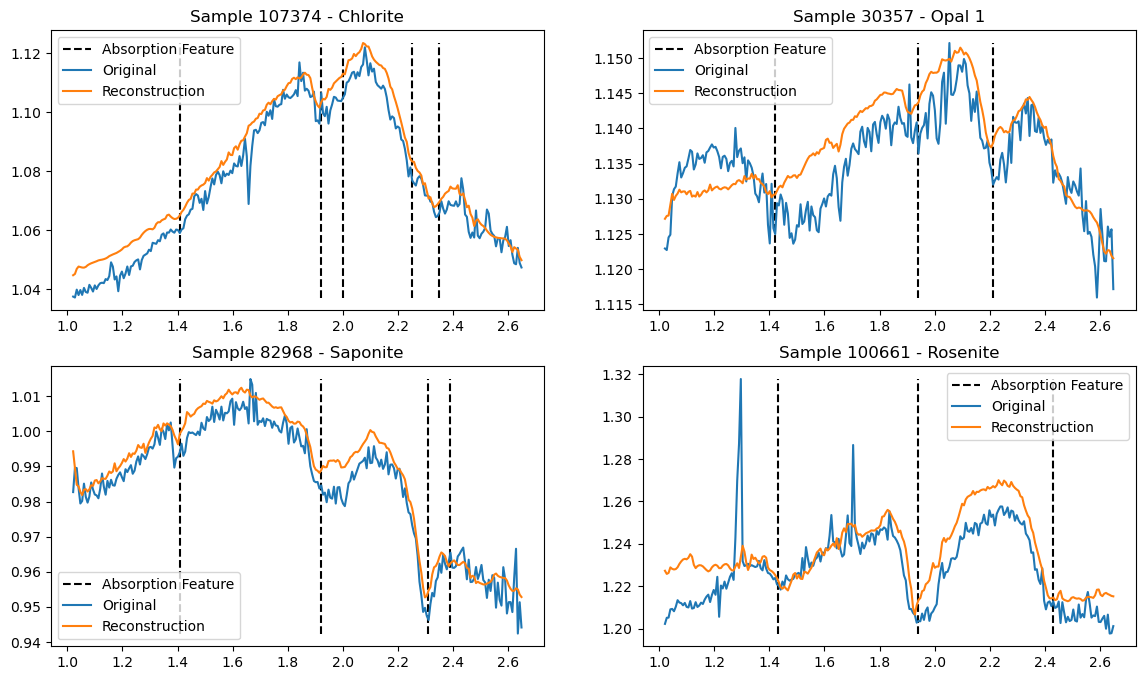

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
indices = np.random.randint(0, dataset_for_recon.data.shape[0], 4)

inputs = dataset_for_recon.data[indices]
spectra_max = torch.max(inputs, dim=-1, keepdim=True).values
spectra_min = torch.min(inputs, dim=-1, keepdim=True).values
scaled_inputs = (inputs - spectra_min) / (spectra_max - spectra_min)

recon = model.forward(scaled_inputs.unsqueeze(1), dataset_for_recon.labels[indices].unsqueeze(1))
recon = recon[0].squeeze()
# inverse scale
recon = recon * (spectra_max - spectra_min) + spectra_min
recon = recon.detach().numpy()

for i, idx in enumerate(indices):
    # plot the diagnostic absorption features
    mineral_class = CLASS_NAMES[dataset_for_recon.labels[idx].item()]
    type_spectra_class = type_spectra_labels[dataset_for_recon.labels[idx].item()+1] # +1 for 1-indexing
    absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
    ax[i//2, i%2].vlines(absorption_feats, ymin=min(recon[i].min(), dataset_for_recon.data[idx][:248].min().item()), ymax=max(recon[i].max(), dataset_for_recon.data[idx][:248].max().item()), color="black", linestyle="--", label="Absorption Feature")
    ax[i//2, i%2].plot(PLEBANI_WAVELENGTHS[:248], dataset_for_recon.data[idx][:248], label="Original")
    ax[i//2, i%2].plot(PLEBANI_WAVELENGTHS[:248], recon[i], label="Reconstruction")
    ax[i//2, i%2].set_title(f"Sample {idx} - {mineral_class}")
    ax[i//2, i%2].legend()

Plot the 4 given in the figure in the paper

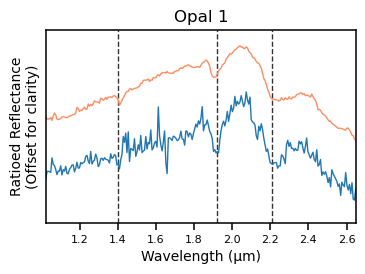

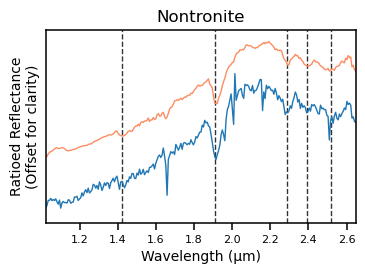

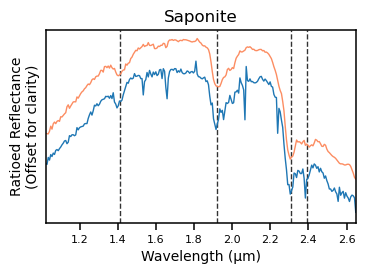

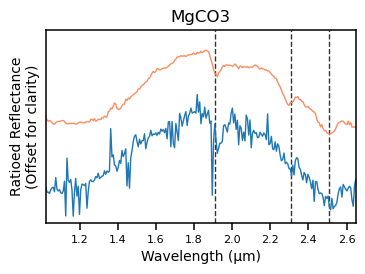

In [ ]:
indices = [31079, 36928, 82171, 108438]

font_size=10

inputs = dataset_for_recon.data[indices]
spectra_max = torch.max(inputs, dim=-1, keepdim=True).values
spectra_min = torch.min(inputs, dim=-1, keepdim=True).values
scaled_inputs = (inputs - spectra_min) / (spectra_max - spectra_min)

recon = model.forward(
    scaled_inputs.unsqueeze(1), dataset_for_recon.labels[indices].unsqueeze(1)
)
recon = recon[0].squeeze()
# inverse scale
recon = recon * (spectra_max - spectra_min) + spectra_min
recon = recon.detach().numpy()

for i, idx in enumerate(indices):
    fig, ax = plt.subplots(figsize=(4, 2.5))
    # plot the diagnostic absorption features
    mineral_class = CLASS_NAMES[dataset_for_recon.labels[idx].item()]
    type_spectra_class = type_spectra_labels[
        dataset_for_recon.labels[idx].item() + 1
    ]  # +1 for 1-indexing
    absorption_feats = CRISM_diagnostic_mineral_features[type_spectra_class]
    absorption_feats = [x for x in absorption_feats if x < 2.6]
    if mineral_class == "Opal 1":
        absorption_feats[0] = 1.4
        absorption_feats[1] = 1.92
    if i == 3:
        max_offset = 0.1
    else:
        max_offset = 0.03
    y_min = (
        min(recon[i].min(), dataset_for_recon.data[idx][:248].min().item())
        - 0.01
    )
    y_max = (
        max(recon[i].max(), dataset_for_recon.data[idx][:248].max().item())
        + max_offset
    )
    ax.vlines(
        absorption_feats,
        ymin=y_min,
        ymax=y_max,
        color="black",
        alpha=0.8,
        linewidth=1,
        linestyle="--",
        label="Absorption Feature",
    )
    ax.plot(
        PLEBANI_WAVELENGTHS[:248],
        dataset_for_recon.data[idx][:248],
        linewidth=1,
        label="Original",
    )
    ax.plot(PLEBANI_WAVELENGTHS[:248], recon[i] + max_offset, linewidth=1, label="Reconstruction", c="#FC8D62")
    ax.spines[:].set_linewidth(1.1)
    ax.set_xlabel("Wavelength (μm)", fontsize=font_size)
    ax.set_ylabel("Ratioed Reflectance\n(Offset for clarity)", fontsize=font_size)
    ax.set_xlim(PLEBANI_WAVELENGTHS[0], PLEBANI_WAVELENGTHS[247])
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(np.arange(1.2, 2.8, 0.2))
    ax.tick_params(axis='both', which='major', width=1.1, length=5, labelsize=font_size-2)
    ax.tick_params(axis='both', which='minor', width=1.1, length=5, labelsize=font_size-2)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title(f"{mineral_class}", fontsize=font_size+2)